In [207]:
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree
from german_holidays import get_german_holiday_calendar
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [209]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20,20)
plt.style.use('tableau-colorblind10')

In [210]:
#Impoting German Holidays
# cal_cls = get_german_holiday_calendar('NW')
# cal = cal_cls()

# holidays = [
#         h.date() for h in pd.to_datetime(
#                     cal.holidays(start='2012', end='2020')
#                     )
#         ]

In [211]:
#reading the data
main_df = pd.read_csv('AEP_hourly.csv', parse_dates=True)
print("hii")
main_df.head()


hii


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


# Augmented Dickey-Fuller test

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [204]:
X_1 = main_df.AEP_MW
result = adfuller(X_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.446812
p-value: 0.000000


As the p-value is <= 0.05 our hypothesis is failed and the data is stationary 

In [160]:
#making date as index
main_df['Datetime'] = pd.to_datetime(main_df['Datetime']).dt.date
main_df = pd.DataFrame(main_df.groupby(main_df['Datetime'])['AEP_MW'].sum())
main_df.head()


,AEP_MW
Datetime,
2004-10-01,328544.0
2004-10-02,311997.0
2004-10-03,293450.0
2004-10-04,343417.0
2004-10-05,346553.0


In [161]:
#describing the updated dataframe
main_df.describe()

,AEP_MW
count,5055.000000
mean,371844.218991
std,47605.308633
min,14809.000000
25%,337265.500000
50%,366539.000000
75%,403198.500000
max,548349.000000


In [162]:
#Checking Null values in DataFrame
main_df.isnull().sum()

AEP_MW    0
dtype: int64

Text(0.5, 1.0, 'Original dataset with no. of daiy sales')

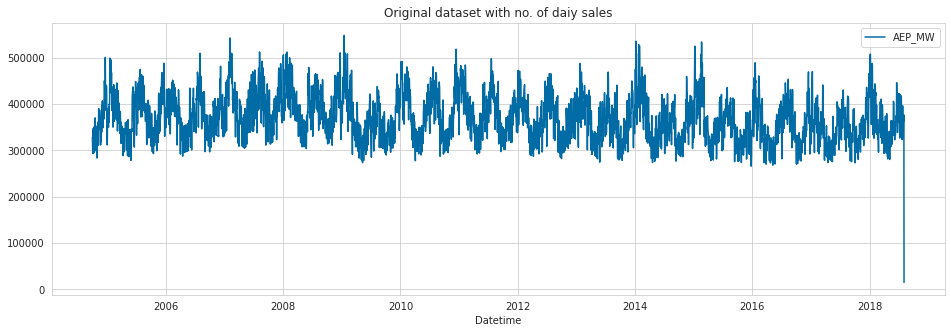

In [163]:
#plotting the data to describe the no.of daily sales
main_df.plot(figsize=(16,5))
plt.title('Original dataset with no. of daiy sales')


ValueError: could not convert string to float: '2004-12-31 01:00:00'

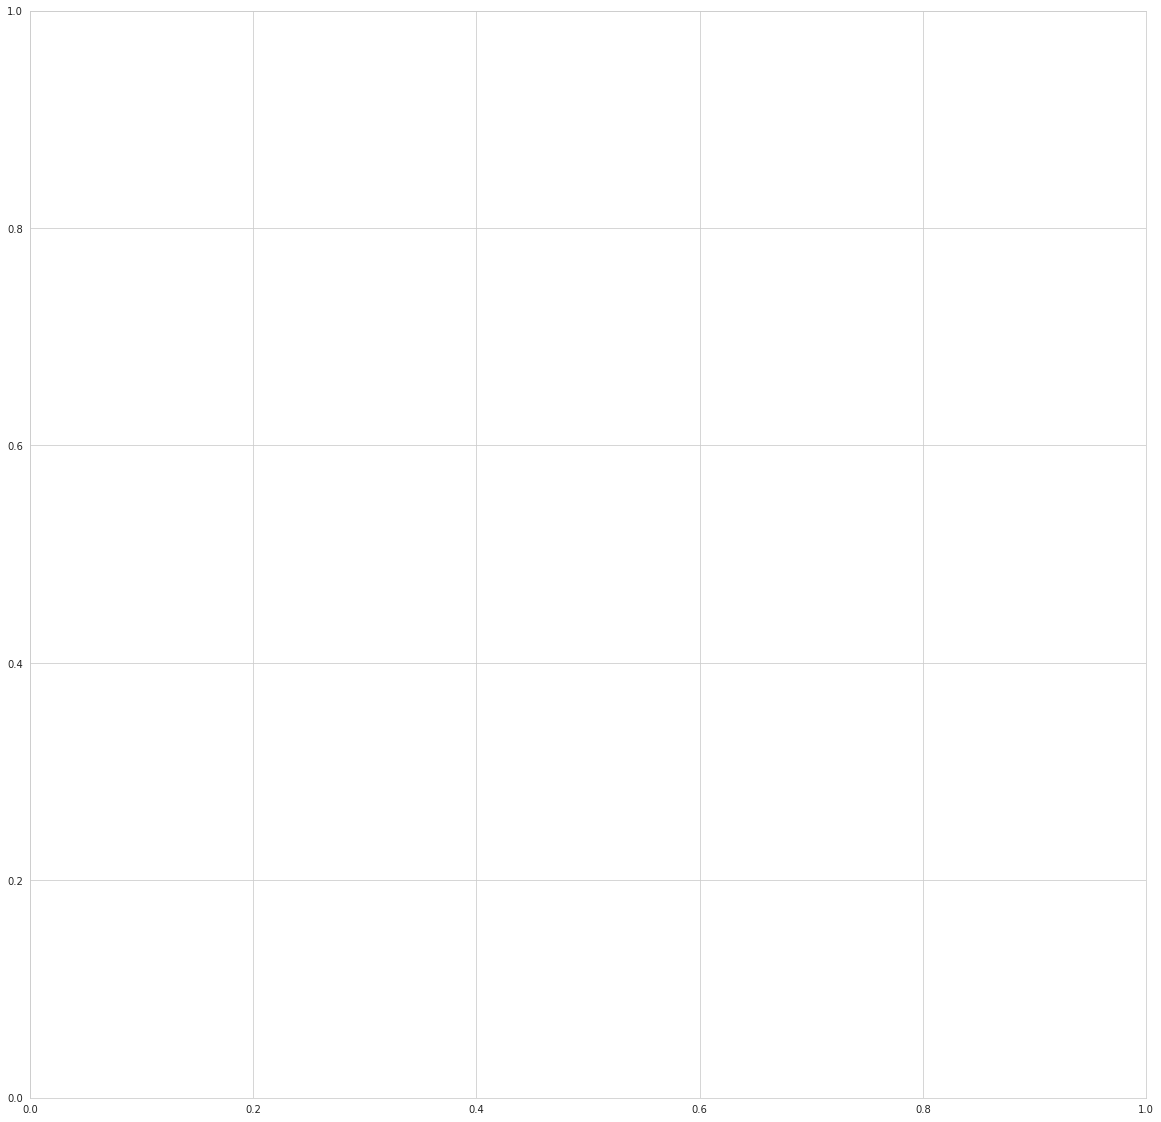

In [206]:
#Check the above graph to decide where to split train and test data

training_df = main_df.groupby(['Datetime'])['AEP_MW'].sum().reset_index()
training_df['Date'] = pd.to_datetime(training_df['Datetime']).dt.date
training_df.head()
print(plot_acf(main_df, lags=50))

In [165]:
# training_df = training_df[training_df['Date'].isin(holidays) == False]
training_df['Datetime'] = pd.to_datetime(training_df['Datetime'])
training_df.head()

,Datetime,AEP_MW,Date
0,2004-10-01,328544.0,2004-10-01
1,2004-10-02,311997.0,2004-10-02
2,2004-10-03,293450.0,2004-10-03
3,2004-10-04,343417.0,2004-10-04
4,2004-10-05,346553.0,2004-10-05


In [166]:
training_df.shape

(5055, 3)

In [167]:
#splitting data on setting index
training_df.set_index('Datetime', inplace=True)
training_df = training_df['2012-06-01':]
training_df.head()

,AEP_MW,Date
Datetime,,
2012-06-01,337401.0,2012-06-01
2012-06-02,296422.0,2012-06-02
2012-06-03,298805.0,2012-06-03
2012-06-04,347547.0,2012-06-04
2012-06-05,338086.0,2012-06-05


In [168]:
training_df.shape

(2255, 2)

Text(0.5, 1.0, 'Training data from 2012 onwards upto 2016')

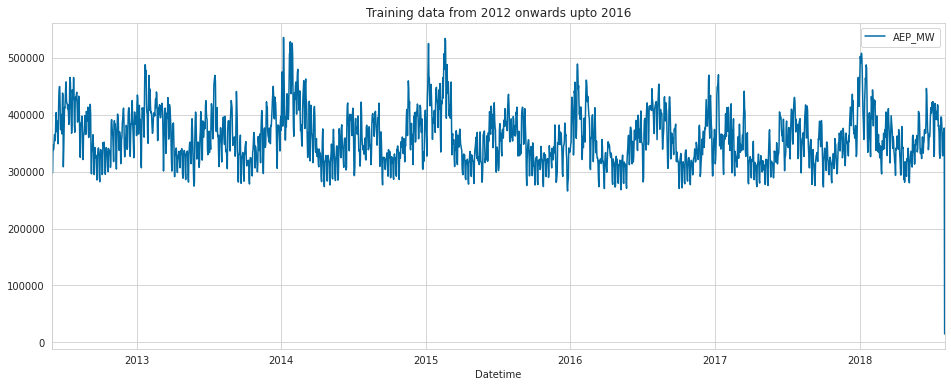

In [169]:
#training data from the date we choosen from 2012
training_df.plot(figsize=(16,6))
plt.title('Training data from 2012 onwards upto 2016')

In [170]:
training_df.head()

,AEP_MW,Date
Datetime,,
2012-06-01,337401.0,2012-06-01
2012-06-02,296422.0,2012-06-02
2012-06-03,298805.0,2012-06-03
2012-06-04,347547.0,2012-06-04
2012-06-05,338086.0,2012-06-05


In [171]:
#describing the traning dataset
training_df.describe()

,AEP_MW
count,2255.000000
mean,359532.725942
std,46151.277189
min,14809.000000
25%,325133.000000
50%,354255.000000
75%,391288.000000
max,535660.000000


In [172]:
#Extracting more info settings for the xgboost
training_df['Year'] = pd.to_datetime(training_df['Date']).dt.year
training_df['Week'] = pd.to_datetime(training_df['Date']).dt.week
training_df['Day'] = pd.to_datetime(training_df['Date']).dt.day
training_df['WeekDay'] = pd.to_datetime(training_df['Date']).dt.dayofweek
#input sequence(t-n,...t-1)
for i in range(7,0,-1):
    training_df['lag' + str(i)] = training_df['AEP_MW'].shift(i)

# training_df['Weekend'] = training_df.WeekDay.isin([5, 6]).astype(int)
"data Frame after adding more info as columns"
training_df.head()
training_df.dropna(inplace=True)

In [173]:
#finding corr between features added as columns
training_df.corr()

,AEP_MW,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,lag2,lag1
AEP_MW,1.000000,-0.104006,-0.214803,-0.001819,-0.283438,0.589416,0.534759,0.464219,0.470333,0.517156,0.617194,0.826289
Year,-0.104006,1.000000,-0.223134,-0.012214,-0.001223,-0.095460,-0.094905,-0.096014,-0.096863,-0.097410,-0.098007,-0.098766
Week,-0.214803,-0.223134,1.000000,0.068145,-0.000652,-0.220472,-0.224126,-0.228329,-0.229622,-0.229461,-0.227616,-0.222535
Day,-0.001819,-0.012214,0.068145,1.000000,-0.000702,0.040522,0.020602,0.008470,0.003867,0.000521,-0.004025,-0.002304
WeekDay,-0.283438,-0.001223,-0.000652,-0.000702,1.000000,-0.285387,-0.211253,-0.074075,0.055978,0.196512,0.271693,0.044829
lag7,0.589416,-0.095460,-0.220472,0.040522,-0.285387,1.000000,0.838005,0.625369,0.524233,0.477126,0.467802,0.539992
lag6,0.534759,-0.094905,-0.224126,0.020602,-0.211253,0.838005,1.000000,0.838119,0.625284,0.524165,0.477031,0.467645
lag5,0.464219,-0.096014,-0.228329,0.008470,-0.074075,0.625369,0.838119,1.000000,0.837825,0.625296,0.524038,0.476824
lag4,0.470333,-0.096863,-0.229622,0.003867,0.055978,0.524233,0.625284,0.837825,1.000000,0.838012,0.625294,0.524038
lag3,0.517156,-0.097410,-0.229461,0.000521,0.196512,0.477126,0.524165,0.625296,0.838012,1.000000,0.838011,0.625275


<AxesSubplot:xlabel='AEP_MW'>

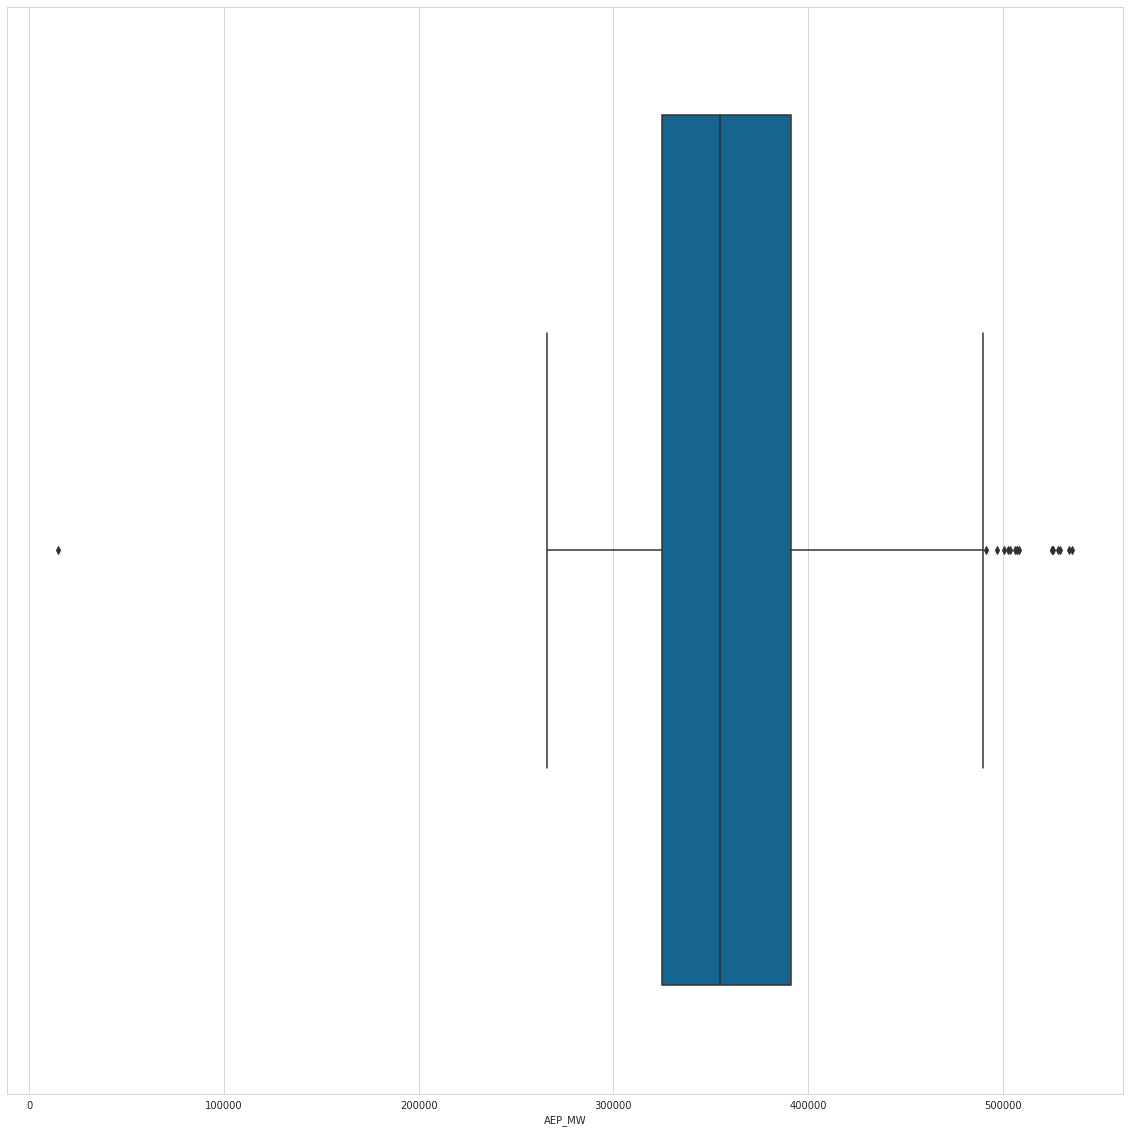

In [174]:
#ploting Sold Units boxplot
sns.boxplot(x=training_df['AEP_MW'])

<AxesSubplot:xlabel='Week', ylabel='AEP_MW'>

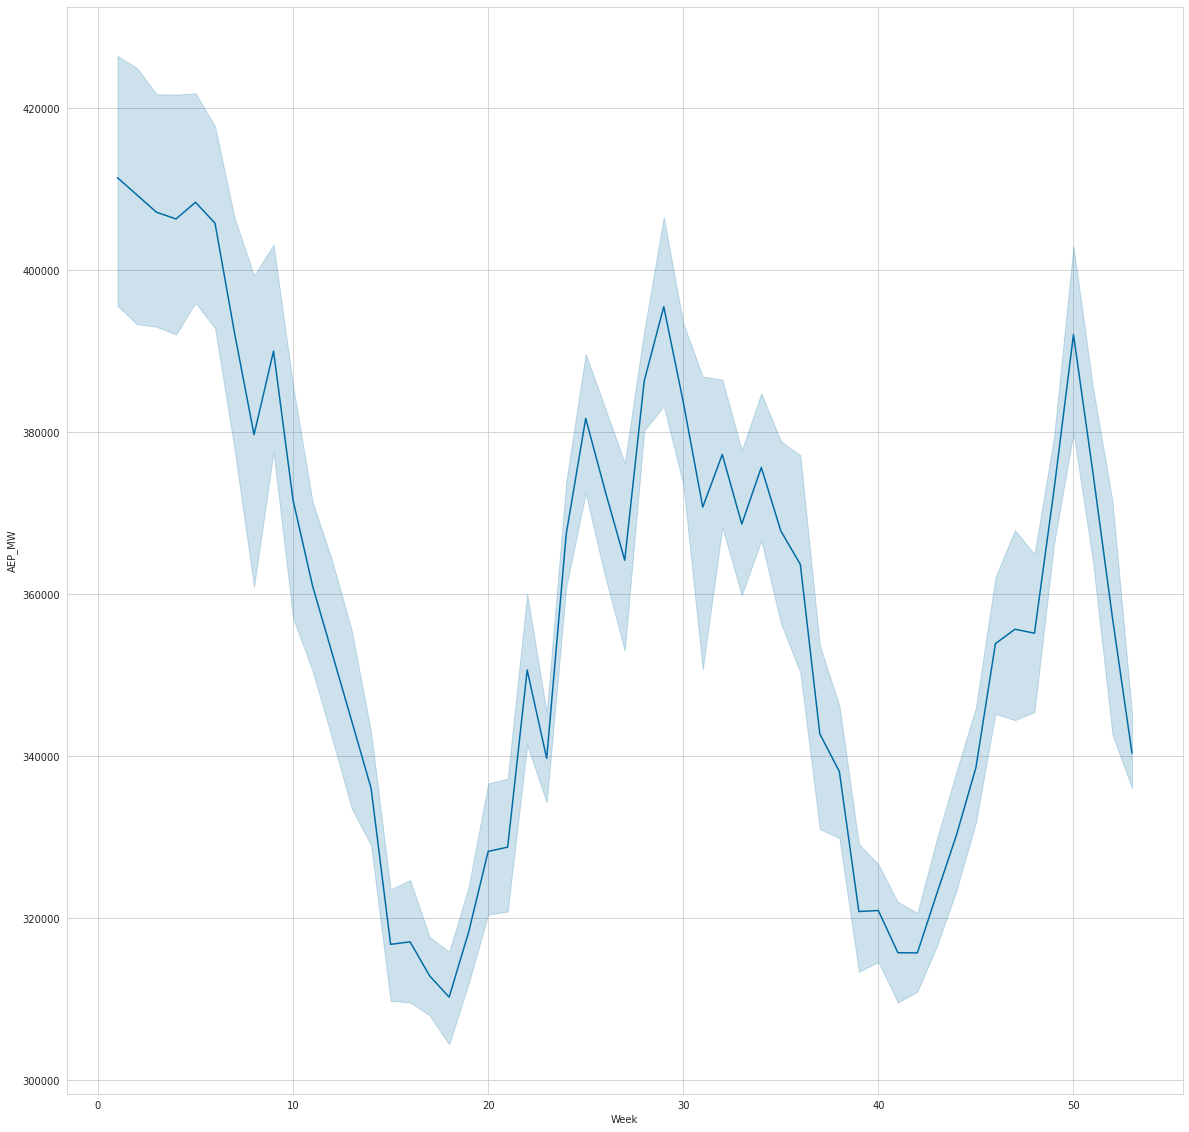

In [175]:
#ploting WEEK VS SOLD UNITS line plot
sns.lineplot(training_df['Week'], training_df['AEP_MW'])

<AxesSubplot:xlabel='Week', ylabel='AEP_MW'>

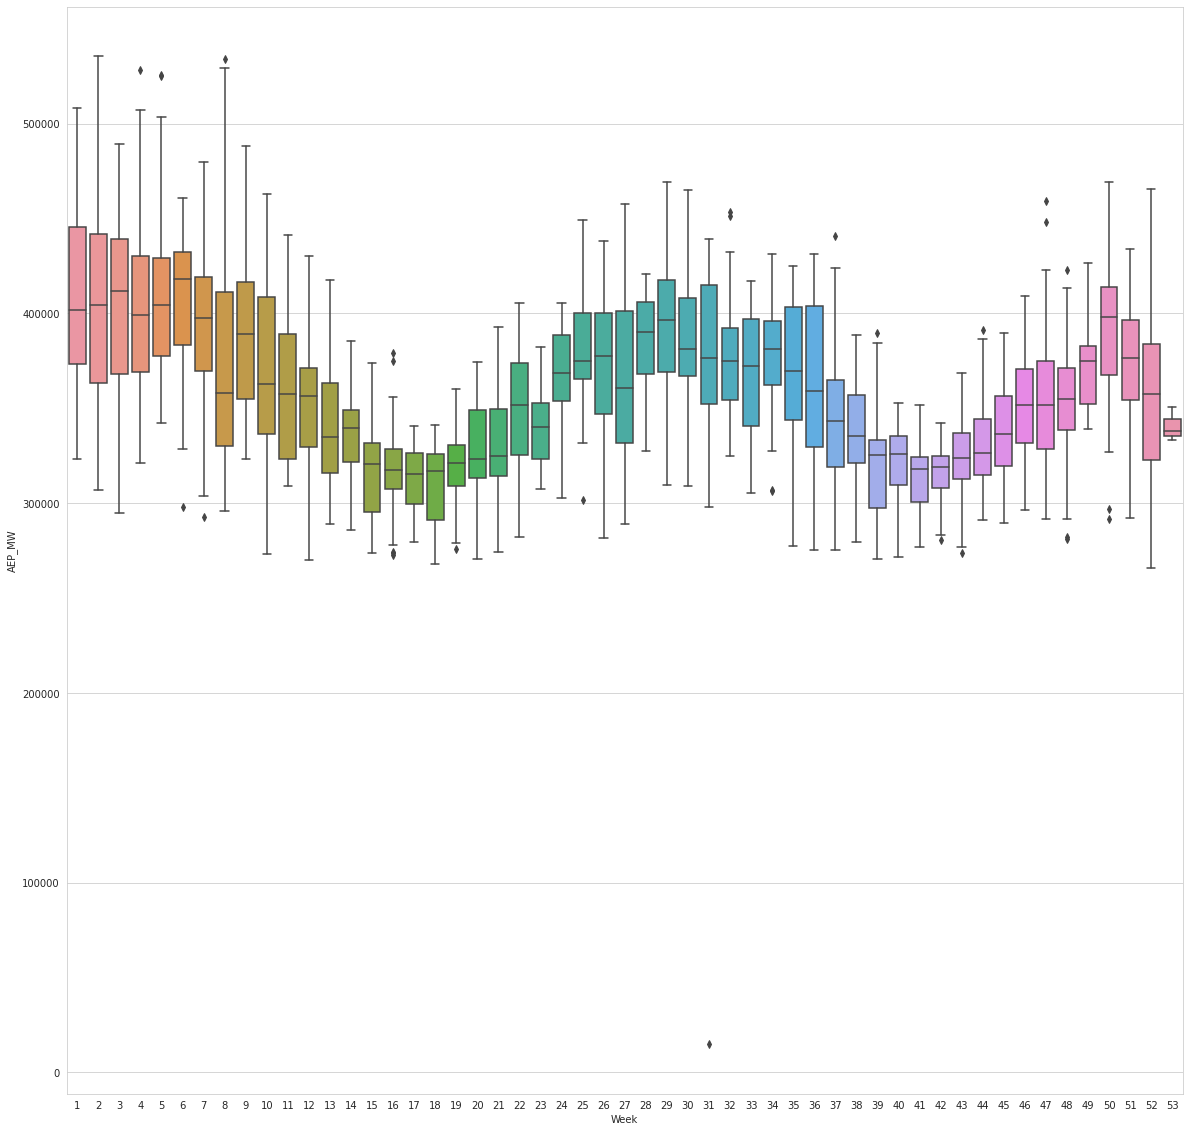

In [176]:
#ploting WEEK VS SOLD UNITS line plot
sns.boxplot(training_df['Week'], training_df['AEP_MW'])

<AxesSubplot:xlabel='Day', ylabel='AEP_MW'>

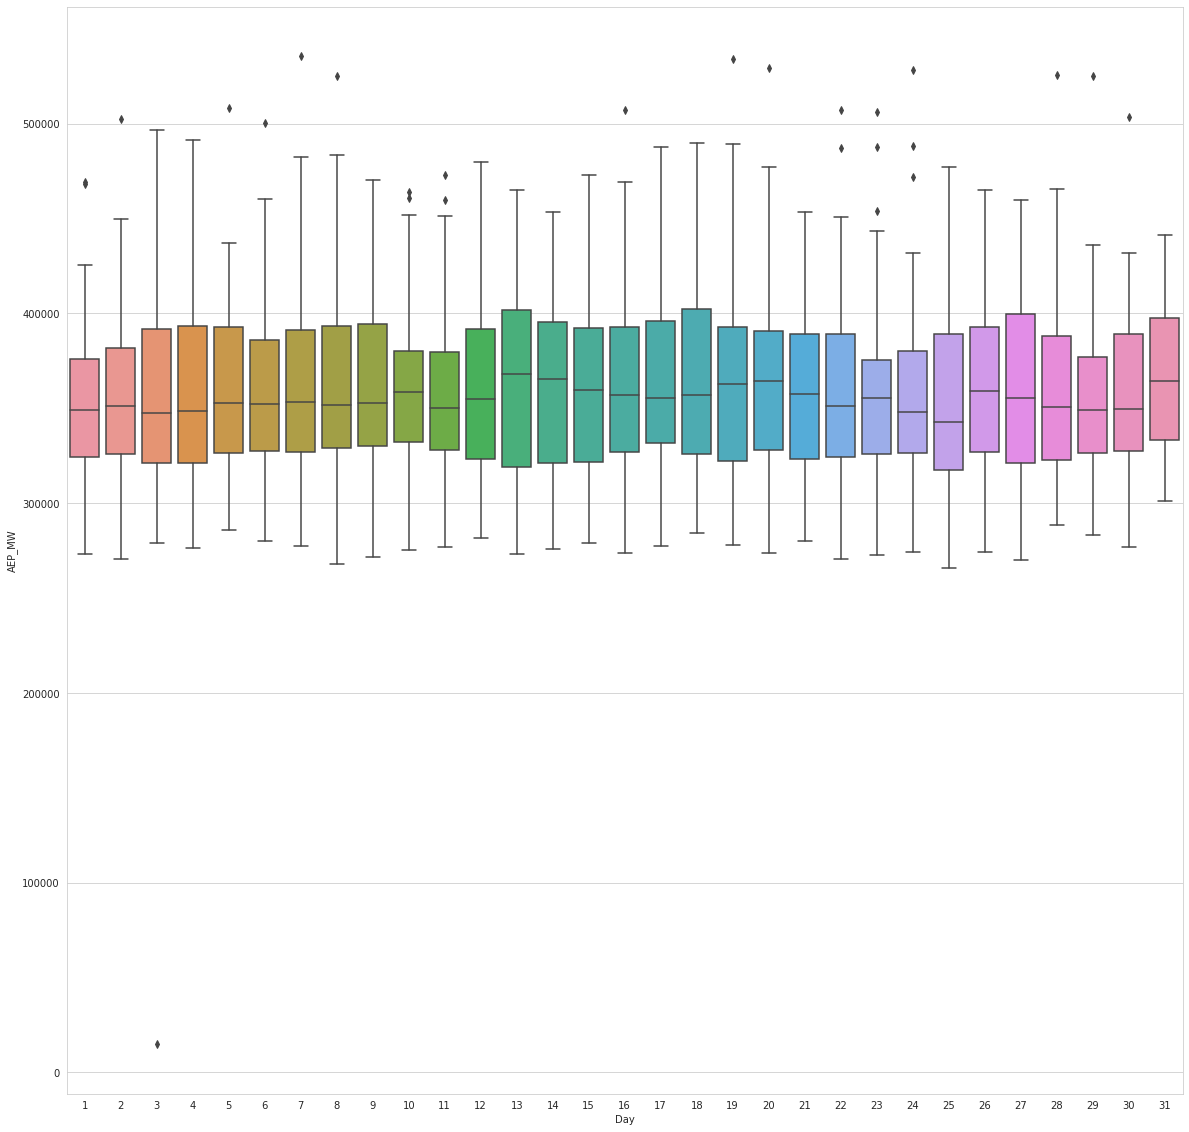

In [177]:
#ploting DAY VS SOLD UNITS line plot
sns.boxplot(training_df['Day'], training_df['AEP_MW'])

In [178]:
training_df.describe()

,AEP_MW,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,lag2,lag1
count,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000
mean,359622.425267,2015.011121,26.598754,15.745552,3.000445,359693.811833,359694.395907,359708.350534,359739.502224,359746.966637,359758.328737,359773.934164
std,46179.147759,1.820704,14.875033,8.798098,2.000111,45638.123334,45637.846306,45623.284635,45605.585725,45604.962465,45602.745147,45602.470361
min,14809.000000,2012.000000,1.000000,1.000000,0.000000,265873.000000,265873.000000,265873.000000,265873.000000,265873.000000,265873.000000,265873.000000
25%,325135.000000,2013.000000,14.000000,8.000000,1.000000,325128.500000,325128.500000,325135.000000,325196.250000,325196.250000,325196.250000,325196.250000
50%,354491.000000,2015.000000,27.000000,16.000000,3.000000,354229.500000,354229.500000,354229.500000,354280.500000,354390.500000,354491.000000,354516.500000
75%,391312.250000,2017.000000,39.000000,23.000000,5.000000,391312.250000,391312.250000,391312.250000,391312.250000,391312.250000,391312.250000,391312.250000
max,535660.000000,2018.000000,53.000000,31.000000,6.000000,535660.000000,535660.000000,535660.000000,535660.000000,535660.000000,535660.000000,535660.000000


In [179]:
#selecting soldunits MIN and Max ranges in data frames
training_df = training_df[training_df['AEP_MW']>290000]
training_df.head()

,AEP_MW,Date,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,lag2,lag1
Datetime,,,,,,,,,,,,,
2012-06-08,365182.0,2012-06-08,2012,23,8,4,337401.0,296422.0,298805.0,347547.0,338086.0,341423.0,355401.0
2012-06-09,354204.0,2012-06-09,2012,23,9,5,296422.0,298805.0,347547.0,338086.0,341423.0,355401.0,365182.0
2012-06-10,360195.0,2012-06-10,2012,23,10,6,298805.0,347547.0,338086.0,341423.0,355401.0,365182.0,354204.0
2012-06-11,390466.0,2012-06-11,2012,24,11,0,347547.0,338086.0,341423.0,355401.0,365182.0,354204.0,360195.0
2012-06-12,403709.0,2012-06-12,2012,24,12,1,338086.0,341423.0,355401.0,365182.0,354204.0,360195.0,390466.0


In [180]:
training_df = training_df[training_df['AEP_MW'] < 490000]

In [181]:
training_df.drop(['Date'], axis=1, inplace=True)
training_df.dtypes

AEP_MW     float64
Year         int64
Week         int64
Day          int64
WeekDay      int64
lag7       float64
lag6       float64
lag5       float64
lag4       float64
lag3       float64
lag2       float64
lag1       float64
dtype: object

In [182]:
training_df.size

25548

In [183]:
training_df.head()


,AEP_MW,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,lag2,lag1
Datetime,,,,,,,,,,,,
2012-06-08,365182.0,2012,23,8,4,337401.0,296422.0,298805.0,347547.0,338086.0,341423.0,355401.0
2012-06-09,354204.0,2012,23,9,5,296422.0,298805.0,347547.0,338086.0,341423.0,355401.0,365182.0
2012-06-10,360195.0,2012,23,10,6,298805.0,347547.0,338086.0,341423.0,355401.0,365182.0,354204.0
2012-06-11,390466.0,2012,24,11,0,347547.0,338086.0,341423.0,355401.0,365182.0,354204.0,360195.0
2012-06-12,403709.0,2012,24,12,1,338086.0,341423.0,355401.0,365182.0,354204.0,360195.0,390466.0


In [184]:
training_df.head()

,AEP_MW,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,lag2,lag1
Datetime,,,,,,,,,,,,
2012-06-08,365182.0,2012,23,8,4,337401.0,296422.0,298805.0,347547.0,338086.0,341423.0,355401.0
2012-06-09,354204.0,2012,23,9,5,296422.0,298805.0,347547.0,338086.0,341423.0,355401.0,365182.0
2012-06-10,360195.0,2012,23,10,6,298805.0,347547.0,338086.0,341423.0,355401.0,365182.0,354204.0
2012-06-11,390466.0,2012,24,11,0,347547.0,338086.0,341423.0,355401.0,365182.0,354204.0,360195.0
2012-06-12,403709.0,2012,24,12,1,338086.0,341423.0,355401.0,365182.0,354204.0,360195.0,390466.0


In [185]:
#test train split on the dataset
#select the date at which want to split as satisfying train test split strategy
split_date = '2016-10-01'
df_train = training_df.loc[training_df.index <= split_date].copy()
df_test = training_df.loc[training_df.index > split_date].copy()

In [186]:
df_train.shape
df_train.head()

,AEP_MW,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,lag2,lag1
Datetime,,,,,,,,,,,,
2012-06-08,365182.0,2012,23,8,4,337401.0,296422.0,298805.0,347547.0,338086.0,341423.0,355401.0
2012-06-09,354204.0,2012,23,9,5,296422.0,298805.0,347547.0,338086.0,341423.0,355401.0,365182.0
2012-06-10,360195.0,2012,23,10,6,298805.0,347547.0,338086.0,341423.0,355401.0,365182.0,354204.0
2012-06-11,390466.0,2012,24,11,0,347547.0,338086.0,341423.0,355401.0,365182.0,354204.0,360195.0
2012-06-12,403709.0,2012,24,12,1,338086.0,341423.0,355401.0,365182.0,354204.0,360195.0,390466.0


In [193]:
df_test

,AEP_MW,Year,Week,Day,WeekDay,lag7,lag6,lag5,lag4,lag3,...,lag1,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,,,,,,,,,,,,
2016-10-03,310866.0,2016,40,3,0,334557.0,324120.0,319659.0,318712.0,313591.0,...,270336.0,2016-10-03,0,0,4,10,2016,277,3,40
2016-10-04,321058.0,2016,40,4,1,324120.0,319659.0,318712.0,313591.0,282452.0,...,310866.0,2016-10-04,0,1,4,10,2016,278,4,40
2016-10-05,326218.0,2016,40,5,2,319659.0,318712.0,313591.0,282452.0,270336.0,...,321058.0,2016-10-05,0,2,4,10,2016,279,5,40
2016-10-06,331856.0,2016,40,6,3,318712.0,313591.0,282452.0,270336.0,310866.0,...,326218.0,2016-10-06,0,3,4,10,2016,280,6,40
2016-10-07,325892.0,2016,40,7,4,313591.0,282452.0,270336.0,310866.0,321058.0,...,331856.0,2016-10-07,0,4,4,10,2016,281,7,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-29,327792.0,2018,30,29,6,323504.0,369842.0,381373.0,396080.0,395382.0,...,338714.0,2018-07-29,0,6,3,7,2018,210,29,30
2018-07-30,368834.0,2018,31,30,0,369842.0,381373.0,396080.0,395382.0,379599.0,...,327792.0,2018-07-30,0,0,3,7,2018,211,30,31
2018-07-31,364327.0,2018,31,31,1,381373.0,396080.0,395382.0,379599.0,338714.0,...,368834.0,2018-07-31,0,1,3,7,2018,212,31,31


In [188]:
df_test.shape

(632, 12)

In [189]:
#creating features for timeseries to the dataset
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    for i in range(7,0,-1):
        training_df['lag' + str(i)] = training_df['AEP_MW'].shift(i)
    X = df[[
        'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
        'dayofmonth', 'weekofyear','lag7','lag6','lag5','lag4','lag3','lag2','lag1',
    ]]
    if label:
        y = df[label]
        return X, y
    return X

In [190]:
#splitting the data into train and test
X_train, y_train = create_features(df_train, label='AEP_MW')
X_test, y_test = create_features(df_test, label='AEP_MW')

In [191]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag7,lag6,lag5,lag4,lag3,lag2,lag1
Datetime,,,,,,,,,,,,,,
2012-06-08,4,2,6,2012,160,8,23,337401.0,296422.0,298805.0,347547.0,338086.0,341423.0,355401.0
2012-06-09,5,2,6,2012,161,9,23,296422.0,298805.0,347547.0,338086.0,341423.0,355401.0,365182.0
2012-06-10,6,2,6,2012,162,10,23,298805.0,347547.0,338086.0,341423.0,355401.0,365182.0,354204.0
2012-06-11,0,2,6,2012,163,11,24,347547.0,338086.0,341423.0,355401.0,365182.0,354204.0,360195.0
2012-06-12,1,2,6,2012,164,12,24,338086.0,341423.0,355401.0,365182.0,354204.0,360195.0,390466.0


In [192]:
y_train.head()

Datetime
2012-06-08    365182.0
2012-06-09    354204.0
2012-06-10    360195.0
2012-06-11    390466.0
2012-06-12    403709.0
Name: AEP_MW, dtype: float64

In [117]:
#creating XGBoost Model
#Tunning the Hyper Parameters with  GridSearchCV

# here is a Parameter grid for the xgboost
params = {
    'min_child_weight': [4, 5],
    'eta' : [i / 10.0 for i in range(3, 6)],
    'lambda' : [0.2],
    'alpha' : [0.3],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}

In [118]:
# Intializing XGB and GridSearch
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

In [119]:
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
   

In [309]:
# reg = xgb.XGBRegressor(n_estimators=1000)
# reg.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         early_stopping_rounds=50,
#        verbose=False)

In [120]:
gridcv_xgb = grid.best_estimator_
r2_score(y_test, gridcv_xgb.predict(X_test))

0.7823801868684432

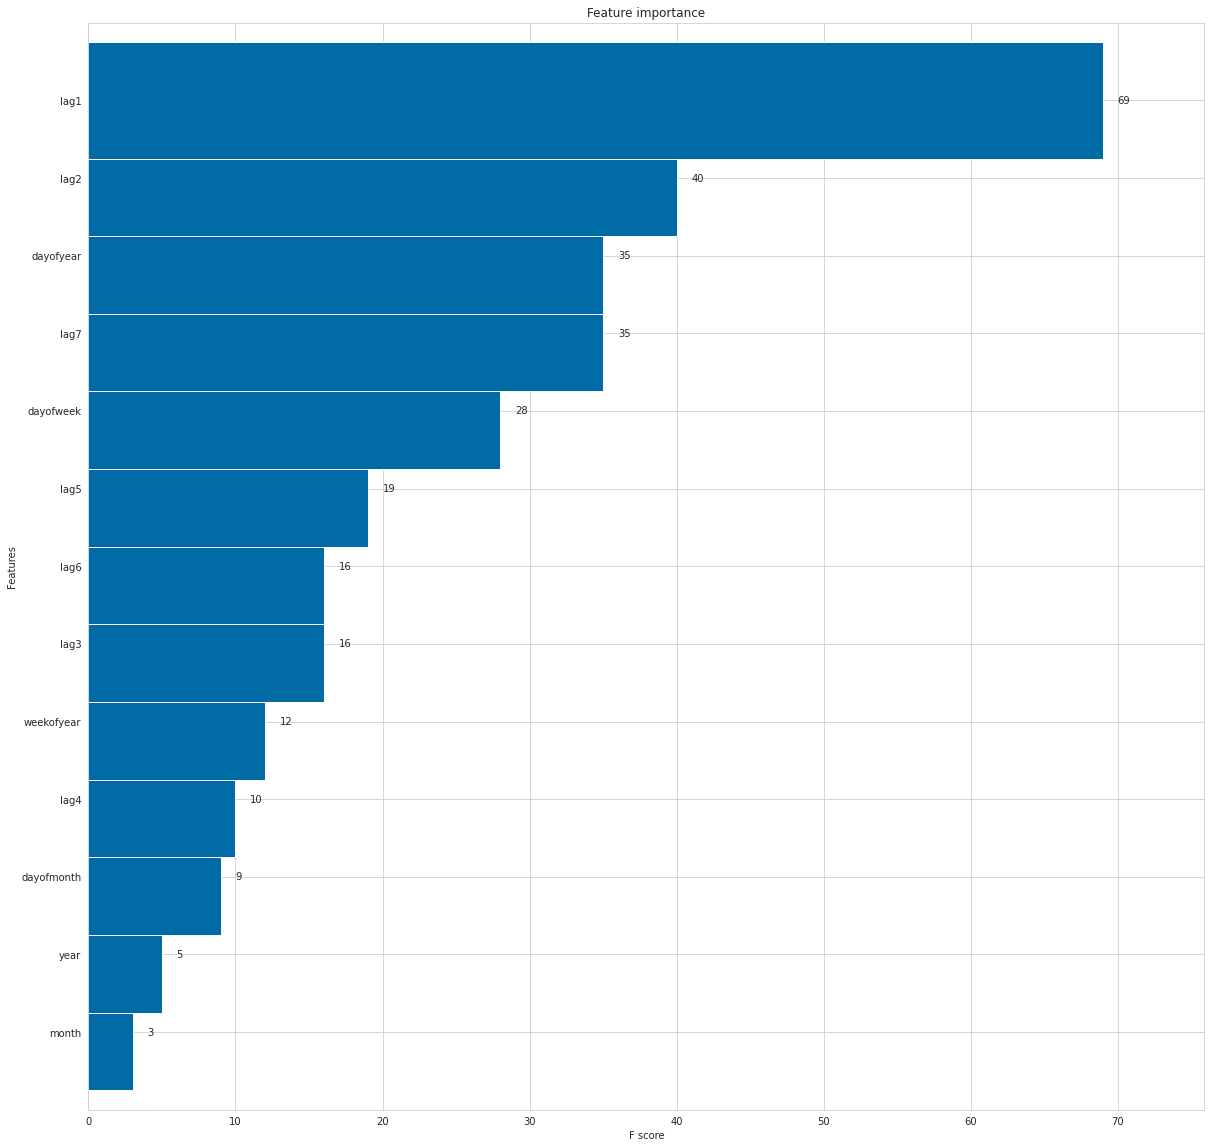

In [121]:
#feature importance graph
_ = plot_importance(gridcv_xgb, height=1.5)
plt.show()

In [122]:
#forecasting the data
df_test['Prediction'] = gridcv_xgb.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

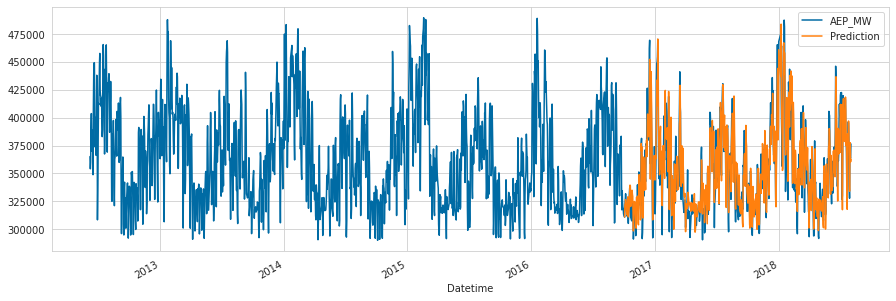

In [123]:
_ = df_all[['AEP_MW','Prediction']].plot(figsize=(15, 5))

In [124]:
#first month predictions
df_all.head().T

Datetime,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07
AEP_MW,310866.0,321058.0,326218.0,331856.0,325892.0
Year,2016,2016,2016,2016,2016
Week,40,40,40,40,40
Day,3,4,5,6,7
WeekDay,0,1,2,3,4
lag7,334557.0,324120.0,319659.0,318712.0,313591.0
lag6,324120.0,319659.0,318712.0,313591.0,282452.0
lag5,319659.0,318712.0,313591.0,282452.0,270336.0
lag4,318712.0,313591.0,282452.0,270336.0,310866.0
lag3,313591.0,282452.0,270336.0,310866.0,321058.0


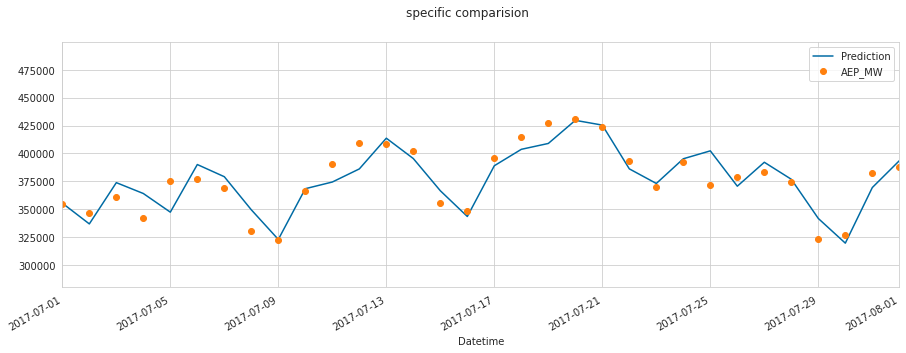

In [205]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Prediction','AEP_MW']].plot(ax=ax, style=['-','o'])
ax.set_xbound(lower='2017-07-01', upper='2017-08-01')
plot = plt.suptitle('specific comparision')

In [126]:
print("root mean squared error")
mean_squared_error(y_true=df_test['AEP_MW'],
                   y_pred=df_test['Prediction'])

root mean squared error


324772746.67829067

In [127]:
print("root absolute error")
mean_absolute_error(y_true=df_test['AEP_MW'],
                   y_pred=df_test['Prediction'])

root absolute error


13982.200158227848

In [128]:
#mean absolute percentage eror
def mean_absolute_percentage_error(y_true, y_pred):
    # """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [129]:
print("mean absolute percentage error")
mean_absolute_percentage_error(y_true=df_test['AEP_MW'],
                   y_pred=df_test['Prediction'])

mean absolute percentage error


3.910010579520831

In [132]:
#Looking at wrost and best predicted days
df_test['error'] = df_test['AEP_MW'] - df_test['Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year', 'month', 'dayofmonth']) \
    .mean()[['AEP_MW', 'Prediction', 'error', 'abs_error']]

In [133]:
print("The Wrost predicted days")
# Over forecasted days
print(error_by_day.sort_values('error', ascending=True).head())

The Wrost predicted days
                         AEP_MW    Prediction        error    abs_error
year month dayofmonth                                                  
2016 11    24          291570.0  360621.62500 -69051.62500  69051.62500
2017 2     11          328529.0  390269.43750 -61740.43750  61740.43750
2016 12    26          293817.0  347894.71875 -54077.71875  54077.71875
           17          378912.0  432500.31250 -53588.31250  53588.31250
2017 2     7           337230.0  386628.25000 -49398.25000  49398.25000


In [134]:
# Best predicted days
print("The Best predicted days")
print(error_by_day.sort_values('abs_error', ascending=True).head())

The Best predicted days
                         AEP_MW    Prediction      error  abs_error
year month dayofmonth                                              
2016 12    23          372437.0  372445.34375   -8.34375    8.34375
2017 5     8           319093.0  319017.43750   75.56250   75.56250
2016 10    3           310866.0  310992.09375 -126.09375  126.09375
2017 5     5           311426.0  311173.50000  252.50000  252.50000
     12    23          326509.0  326228.06250  280.93750  280.93750


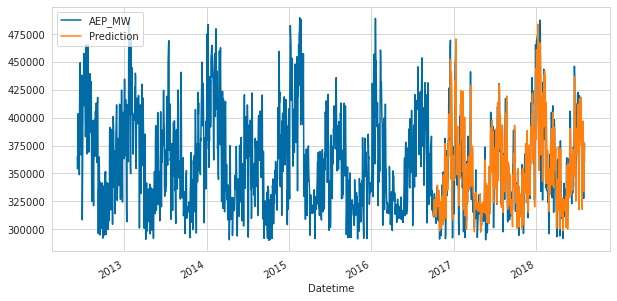

In [143]:
#plotting some best and Wrost predicated days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[[ 'AEP_MW','Prediction']].plot(ax=ax, style=['-','-'])

In [144]:
ax.set_xbound(lower='2019-09-01', upper='2019-10-01')
plot = plt.suptitle('Worst Predicted Days')


<Figure size 1440x1440 with 0 Axes>

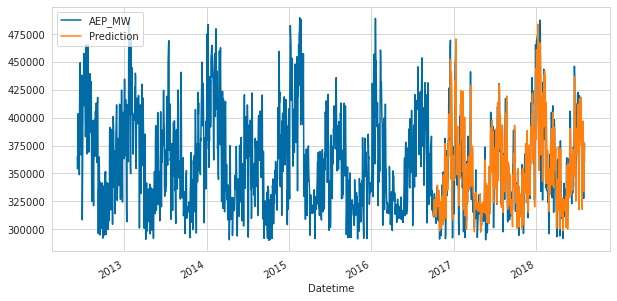

In [149]:
#best predicted days graph
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_all[[ 'AEP_MW','Prediction']].plot(ax=ax, style=['-','-'])

In [151]:
ax.set_xbound(lower='2019-09-01', upper='2019-10-01')
plot = plt.suptitle('Best Predicted Days')

<Figure size 1440x1440 with 0 Axes>

In [152]:
#Forecasting the data
test = pd.read_excel('predictionempty.xlsx', parse_dates=[0], index_col=[0])
pred_x, pred_y = create_features(test, label='Sales')

test['xgb_Prediction'] = gridcv_xgb.predict(pred_x)

KeyError: "['lag7', 'lag6', 'lag5', 'lag4', 'lag3', 'lag2', 'lag1'] not in index"

In [153]:
test.drop(['Sales','hour','dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'date'], axis=1, inplace=True)
test.head()

""
Date
2019-09-30
2019-10-01
2019-10-02
2019-10-03
2019-10-04
